<a href="https://colab.research.google.com/github/cjweems/image-filter-project/blob/feedback/Image_Filter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
cd drive/MyDrive/'AP CSP'/'Image Filter Project'

/content/drive/MyDrive/AP CSP/Image Filter Project


<IPython.core.display.Javascript object>

Saved to photo.jpg


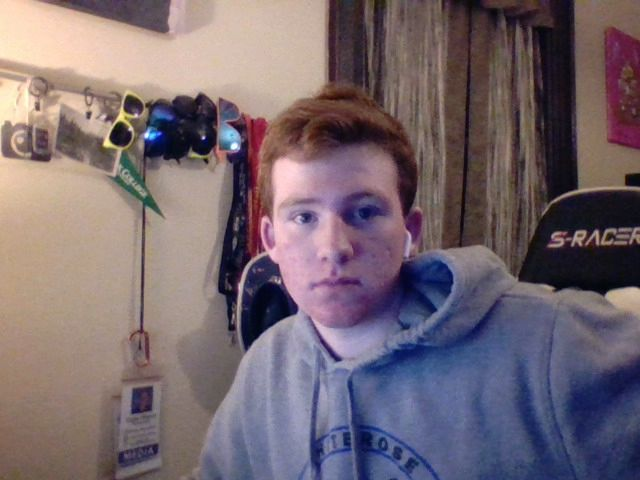

TypeError: ignored

In [22]:
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
  print(str(err))

# Get an image from google drive
# directory = os.getcwd()
# imagePath = os.path.join(directory, 'person.jpg')

# Get the image that was taken
imagePath = cv2.imread('photo.jpg')

# Read the image
img = cv2.imread(imagePath)

# Conver the image to grayscale
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Load the pre-trained classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change

# Preform the face detection
face = face_cascade.detectMultiScale(gray_img,1.1,4)

# Draw the bounding box
for x,y,width,height in face:
  cv2.rectangle(img,(x,y),(x+width,y+height),color = (0,255,0),thickness =1)

# Display the image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')